In [1]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

In [2]:
# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from datetime import datetime
import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import re

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference")

print("\n" + "=" * 80)
print("SETUP COMPLETE - FEW-SHOT RISK ASSESSMENT")
print("=" * 80)
print("Models configured:")
print("  • R4: Llama3.1:8b (Ollama - Local - Few-Shot)")
print("  • R5: Qwen3:8b (Ollama - Local - Few-Shot)")
print("  • R6: DeepSeek-R1:8b (Ollama - Local - Few-Shot)")
print("=" * 80)

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference

SETUP COMPLETE - FEW-SHOT RISK ASSESSMENT
Models configured:
  • R4: Llama3.1:8b (Ollama - Local - Few-Shot)
  • R5: Qwen3:8b (Ollama - Local - Few-Shot)
  • R6: DeepSeek-R1:8b (Ollama - Local - Few-Shot)


## 1. Load Dataset

In [3]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
risks = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                risks.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_risk": risks})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nRisk distribution:")
print(df["true_risk"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Risk distribution:
true_risk
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_risk
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Few-Shot Examples

Carefully curated examples (2 positive, 2 negative, 1 neutral) representing typical financial risk patterns.

In [4]:
# Curated few-shot examples for RISK ASSESSMENT
FEW_SHOT_EXAMPLES = [
    {
        "sentence": "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.",
        "risk": "positive",
        "rationale": "Profit growth reduces business risk and indicates improved financial resilience for investors.",
    },
    {
        "sentence": "Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.",
        "risk": "positive",
        "rationale": "Strong revenue growth signals lower business risk and increases company's ability to weather market challenges.",
    },
    {
        "sentence": "The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.",
        "risk": "negative",
        "rationale": "Shift from profit to loss represents increased financial risk and deteriorating business fundamentals that threaten shareholder value.",
    },
    {
        "sentence": "Sales decreased by 15% year-over-year due to weakening demand in key markets.",
        "risk": "negative",
        "rationale": "Significant revenue decline signals elevated operational risk, market challenges, and potential liquidity concerns for investors.",
    },
    {
        "sentence": "The company announced the appointment of a new chief financial officer effective next month.",
        "risk": "neutral",
        "rationale": "Executive changes are routine corporate announcements without direct implications for immediate investment risk.",
    },
]

print("Few-Shot Examples for RISK ASSESSMENT:")
print("=" * 80)
for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
    print(f"\nExample {i} [{ex['risk'].upper()}]:")
    print(f"Sentence: {ex['sentence']}")
    print(f"Risk Assessment: {ex['rationale']}")

Few-Shot Examples for RISK ASSESSMENT:

Example 1 [POSITIVE]:
Sentence: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.
Risk Assessment: Profit growth reduces business risk and indicates improved financial resilience for investors.

Example 2 [POSITIVE]:
Sentence: Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.
Risk Assessment: Strong revenue growth signals lower business risk and increases company's ability to weather market challenges.

Example 3 [NEGATIVE]:
Sentence: The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.
Risk Assessment: Shift from profit to loss represents increased financial risk and deteriorating business fundamentals that threaten shareholder value.

Example 4 [NEGATIVE]:
Sentence: Sales decreased by 15% year-over-year due to weakening demand in key markets.
Risk Assessment: Significant revenue decline signals elevated operation

## 3. Few-Shot Prompt Design

In [5]:
def create_few_shot_prompt(sentence):
    """
    Creates a few-shot prompt with 5 labeled examples for financial risk assessment.
    """
    examples_text = ""
    for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
        examples_text += f"""\nExample {i}:
            Sentence: "{ex["sentence"]}"
            Analysis:
            {{
                "risk": "{ex["risk"]}",
                "confidence": 0.95,
                "rationale": "{ex["rationale"]}"
            }}
    """

    prompt = f"""You are a financial risk assessment expert specializing in investment analysis.

Analyze the following financial statement and classify its impact on investment risk as "positive", "negative", or "neutral".

Guidelines:
- Positive: Opportunity signals that reduce investment risk (revenue growth, profit increase, market expansion)
- Negative: Threat signals that increase investment risk (losses, declining sales, operational challenges)
- Neutral: Informational content with no direct risk implications

Here are 5 examples to learn from:
{examples_text}

Now classify this new statement:
Sentence: "{sentence}"

Provide your response in JSON format:
{{
    "risk": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence of how this affects investment risk"
}}
"""
    return prompt


# Test prompt
test_sentence = "The company's quarterly revenue exceeded analyst expectations by 12%."
print("=" * 80)
print("FEW-SHOT PROMPT EXAMPLE (RISK ASSESSMENT)")
print("=" * 80)
print(create_few_shot_prompt(test_sentence)[:1000] + "...")

FEW-SHOT PROMPT EXAMPLE (RISK ASSESSMENT)
You are a financial risk assessment expert specializing in investment analysis.

Analyze the following financial statement and classify its impact on investment risk as "positive", "negative", or "neutral".

Guidelines:
- Positive: Opportunity signals that reduce investment risk (revenue growth, profit increase, market expansion)
- Negative: Threat signals that increase investment risk (losses, declining sales, operational challenges)
- Neutral: Informational content with no direct risk implications

Here are 5 examples to learn from:

Example 1:
            Sentence: "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
            Analysis:
            {
                "risk": "positive",
                "confidence": 0.95,
                "rationale": "Profit growth reduces business risk and indicates improved financial resilience for investors."
            }
    
Example 2:
            Sentence: "Net 

## 4. Model Inference Functions

In [6]:
# Ollama API configuration
OLLAMA_BASE_URL = "http://localhost:11434/api/generate"


def call_ollama(model_name, prompt, temperature=0.0):
    """Generic function to call Ollama API for any model"""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_BASE_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "temperature": temperature,
                    "stream": False,
                },
                timeout=120,
            )
            if response.status_code == 200:
                return response.json().get("response", "")
            else:
                print(f"⚠️  Ollama API error: {response.status_code}")
                if attempt < max_retries - 1:
                    time.sleep(2**attempt)
                    continue
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2**attempt)
                continue
            print(f"Error calling Ollama: {e}")
            return None
    return None


def call_llama(prompt, temperature=0.0):
    """Call Llama3.1:8b via Ollama API (R4)"""
    return call_ollama("llama3.1:8b", prompt, temperature)


def call_qwen(prompt, temperature=0.0):
    """Call Qwen3:8b via Ollama API (R5)"""
    return call_ollama("qwen3:8b", prompt, temperature)


def call_deepseek(prompt, temperature=0.0):
    """Call DeepSeek-R1:8b via Ollama API (R6)"""
    return call_ollama("deepseek-r1:8b", prompt, temperature)

def parse_response(response_text):
    """Robustly parse JSON response, handling conversational filler and markdown blocks."""
    if not response_text:
        return None
        
    try:
        # 1. Try to extract from Markdown code blocks (```json ... ```)
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            # 2. Use Regex to find the first '{' and last '}'
            # This is the "magic" fix for Llama/DeepSeek chatter
            match = re.search(r'(\{.*\})', response_text, re.DOTALL)
            if match:
                json_str = match.group(1).strip()
            else:
                json_str = response_text.strip()

        result = json.loads(json_str)
        
        # Handle 'sentiment' vs 'risk' key mapping
        if 'sentiment' in result and 'risk' not in result:
            result['risk'] = result['sentiment']
        
        return result

    except Exception as e:
        # 3. Fallback logic (Keep your existing keyword search)
        response_lower = response_text.lower()
        if "positive" in response_lower and "negative" not in response_lower:
            return {"risk": "positive", "confidence": 0.5, "rationale": "Regex fail; keyword fallback"}
        elif "negative" in response_lower:
            return {"risk": "negative", "confidence": 0.5, "rationale": "Regex fail; keyword fallback"}
        elif "neutral" in response_lower:
            return {"risk": "neutral", "confidence": 0.5, "rationale": "Regex fail; keyword fallback"}
        return None
    
print("✓ Model inference functions defined")
print("  • call_llama() - Llama3.1:8b (R4)")
print("  • call_qwen() - Qwen3:8b (R5)")
print("  • call_deepseek() - DeepSeek-R1:8b (R6)")
print("  • parse_response() - JSON parser")


✓ Model inference functions defined
  • call_llama() - Llama3.1:8b (R4)
  • call_qwen() - Qwen3:8b (R5)
  • call_deepseek() - DeepSeek-R1:8b (R6)
  • parse_response() - JSON parser


## 5. Run Experiments

### R4: Llama3.1:8b (Few-Shot)

In [7]:
# Test sample (remove .head(200) for full run)
test_df = df.head(200).copy()

# R4: Llama3.1:8b
print("=" * 80)
print("Running R4: Llama3.1:8b (Few-Shot)")
print("=" * 80)
r4_results = []

for idx, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df), desc="R4 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_llama(prompt)

    if response:
        parsed = parse_response(response)
        if parsed:
            r4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": parsed.get("risk", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            r4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        r4_results.append(
            {
                "sentence": row["sentence"],
                "true_risk": row["true_risk"],
                "predicted_risk": "error",
                "confidence": 0,
                "rationale": "API call failed",
            }
        )

    time.sleep(0.5)

r4_df = pd.DataFrame(r4_results)
print(f"\n✓ R4 completed: {len(r4_df)} predictions")
print(
    f"  Valid predictions: {len(r4_df[r4_df['predicted_risk'].isin(['positive', 'negative', 'neutral'])])}"
)
print(f"  Errors: {len(r4_df[r4_df['predicted_risk'] == 'error'])}")
display(r4_df.head())

Running R4: Llama3.1:8b (Few-Shot)


R4 Progress: 100%|██████████| 200/200 [19:52<00:00,  5.96s/it]


✓ R4 completed: 200 predictions
  Valid predictions: 200
  Errors: 0


,sentence,true_risk,predicted_risk,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,0.85,The company's statement suggests that it has a...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Significant revenue growth and shift from pre-...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Strong revenue growth and significant profit i...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.90,Profit growth over a significant period repres...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.90,Operating profit growth indicates improved fin...


### R5: Qwen3:8b (Few-Shot)

In [8]:
# R5: Qwen3:8b
print("\n" + "=" * 80)
print("Running R5: Qwen3:8b (Few-Shot)")
print("=" * 80)
r5_results = []

for idx, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df), desc="R5 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_qwen(prompt)

    if response:
        parsed = parse_response(response)
        if parsed:
            r5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": parsed.get("risk", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            r5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        r5_results.append(
            {
                "sentence": row["sentence"],
                "true_risk": row["true_risk"],
                "predicted_risk": "error",
                "confidence": 0,
                "rationale": "API call failed",
            }
        )

    time.sleep(0.5)

r5_df = pd.DataFrame(r5_results)
print(f"\n✓ R5 completed: {len(r5_df)} predictions")
print(
    f"  Valid predictions: {len(r5_df[r5_df['predicted_risk'].isin(['positive', 'negative', 'neutral'])])}"
)
print(f"  Errors: {len(r5_df[r5_df['predicted_risk'] == 'error'])}")
display(r5_df.head())


Running R5: Qwen3:8b (Few-Shot)


R5 Progress: 100%|██████████| 200/200 [1:45:52<00:00, 31.76s/it]  


✓ R5 completed: 200 predictions
  Valid predictions: 200
  Errors: 0


,sentence,true_risk,predicted_risk,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,0.90,The company's decision to avoid full productio...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Doubling of net sales indicates strong revenue...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Both net sales growth and operating profit exp...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Profit growth reduces business risk and indica...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit growth indicates improved fin...


### R6: DeepSeek-R1:8b

In [9]:
# R6: DeepSeek-R1:8b
print("\n" + "=" * 80)
print("Running R6: DeepSeek-R1:8b (Few-Shot)")
print("=" * 80)
# R6: DeepSeek-R1:8b with few-shot examples

r6_results = []

for idx, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df), desc="R6 Progress"):    
    response = call_deepseek(create_few_shot_prompt(row["sentence"]))

    if response:
        parsed = parse_response(response)
        if parsed:
            r6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": parsed.get("risk", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            r6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_risk": row["true_risk"],
                    "predicted_risk": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        r6_results.append(
            {
                "sentence": row["sentence"],
                "true_risk": row["true_risk"],
                "predicted_risk": "error",
                "confidence": 0,
                "rationale": "Model inference failed",
            }
        )

    time.sleep(0.1)  # Shorter delay for local model

r6_df = pd.DataFrame(r6_results)
print(f"\n✓ R6 completed: {len(r6_df)} predictions")
print(
    f"  Valid predictions: {len(r6_df[r6_df['predicted_risk'].isin(['positive', 'negative', 'neutral'])])}"
)
print(f"  Errors: {len(r6_df[r6_df['predicted_risk'] == 'error'])}")
display(r6_df.head())


Running R6: DeepSeek-R1:8b (Few-Shot)


R6 Progress: 100%|██████████| 200/200 [1:26:34<00:00, 25.97s/it]


✓ R6 completed: 200 predictions
  Valid predictions: 200
  Errors: 0


,sentence,true_risk,predicted_risk,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.95,The statement clarifies production strategy wi...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Revenue doubling demonstrates strong growth po...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Strong operating profit growth indicates impro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Significant operating profit growth reduces fi...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit growth indicates improved ope...


## 6. Calculate Metrics

In [10]:
from sklearn.metrics import matthews_corrcoef


def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics including MCC"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_risk" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_risk"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_risk"]
    y_pred = valid_df["predicted_risk"]

    # Calculate Matthews Correlation Coefficient
    mcc_score = matthews_corrcoef(y_true, y_pred)

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": mcc_score,
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
print("\n" + "=" * 80)
print("CALCULATING METRICS")
print("=" * 80)

r4_metrics, r4_cm, r4_valid = calculate_metrics(r4_df, "R4: Llama3.1:8b (Few-Shot)")
r5_metrics, r5_cm, r5_valid = calculate_metrics(r5_df, "R5: Qwen3:8b (Few-Shot)")
r6_metrics, r6_cm, r6_valid = calculate_metrics(r6_df, "R6: DeepSeek-R1:8b (Few-Shot)")

# Create comparison table
metrics_df = pd.DataFrame([r4_metrics, r5_metrics, r6_metrics])

print("\n" + "=" * 80)
print("FEW-SHOT RISK ASSESSMENT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Valid Predictions", "Accuracy", "Macro-F1", "MCC"]
    ].round(4)
)

print("\n" + "=" * 80)
print("DETAILED METRICS")
print("=" * 80)
display(
    metrics_df[["Experiment", "Macro-Precision", "Macro-Recall", "Weighted-F1"]].round(
        4
    )
)

print("\n" + "=" * 80)
print("PER-CLASS F1 SCORES")
print("=" * 80)
display(metrics_df[["Experiment", "Positive_F1", "Negative_F1", "Neutral_F1"]].round(4))


CALCULATING METRICS

FEW-SHOT RISK ASSESSMENT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Valid Predictions,Accuracy,Macro-F1,MCC
0,R4: Llama3.1:8b (Few-Shot),200,0.925,0.4684,0.2211
1,R5: Qwen3:8b (Few-Shot),200,0.990,0.8974,0.7949
2,R6: DeepSeek-R1:8b (Few-Shot),200,0.960,0.4939,0.5667



DETAILED METRICS


,Experiment,Macro-Precision,Macro-Recall,Weighted-F1
0,R4: Llama3.1:8b (Few-Shot),0.4946,0.4462,0.9477
1,R5: Qwen3:8b (Few-Shot),0.8974,0.8974,0.9900
2,R6: DeepSeek-R1:8b (Few-Shot),0.4545,0.5880,0.9697



PER-CLASS F1 SCORES


,Experiment,Positive_F1,Negative_F1,Neutral_F1
0,R4: Llama3.1:8b (Few-Shot),0.9606,0.0,0.4444
1,R5: Qwen3:8b (Few-Shot),0.9949,0.0,0.8000
2,R6: DeepSeek-R1:8b (Few-Shot),0.9817,0.0,0.5000


## 7. Visualize Results

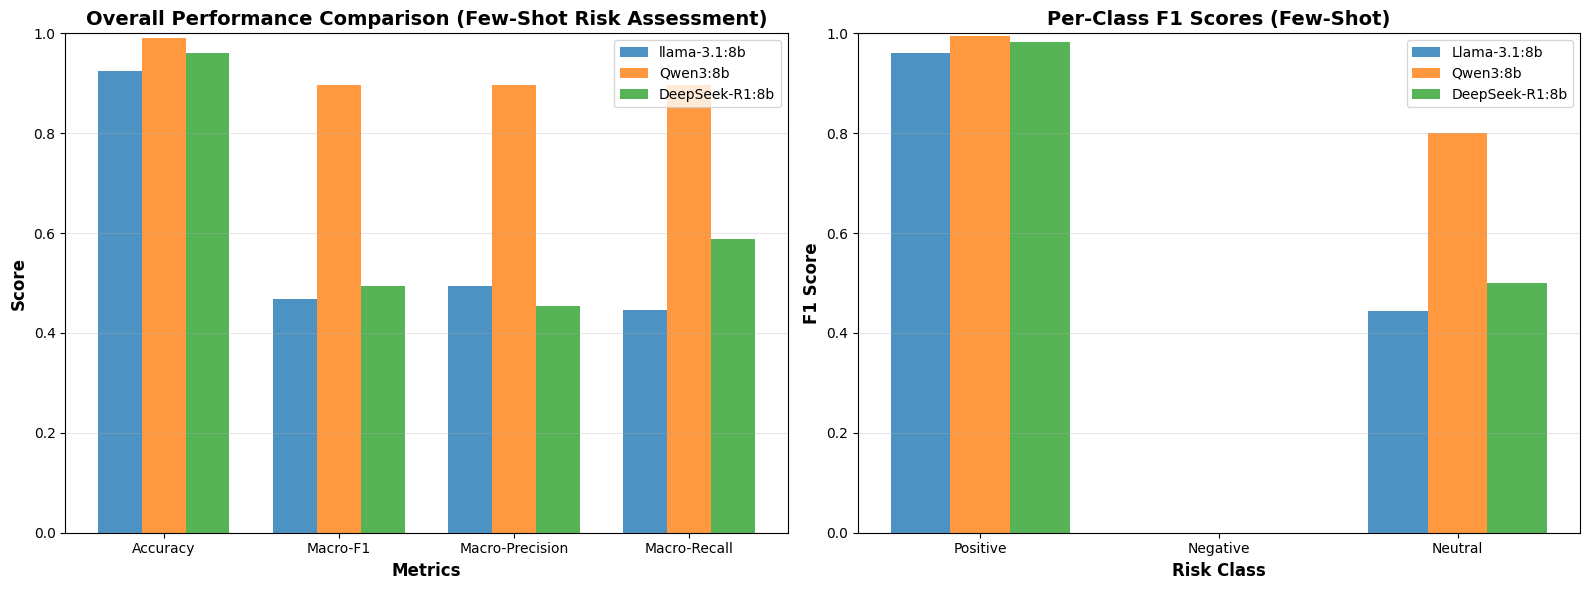

✓ Performance comparison chart saved


In [11]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (r4_metrics, "llama-3.1:8b"),
        (r5_metrics, "Qwen3:8b"),
        (r6_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Few-Shot Risk Assessment)",
    fontsize=14,
    weight="bold",
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (r4_metrics, "Llama-3.1:8b"),
        (r5_metrics, "Qwen3:8b"),
        (r6_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Risk Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Few-Shot)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("few_shot_risk_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Performance comparison chart saved")

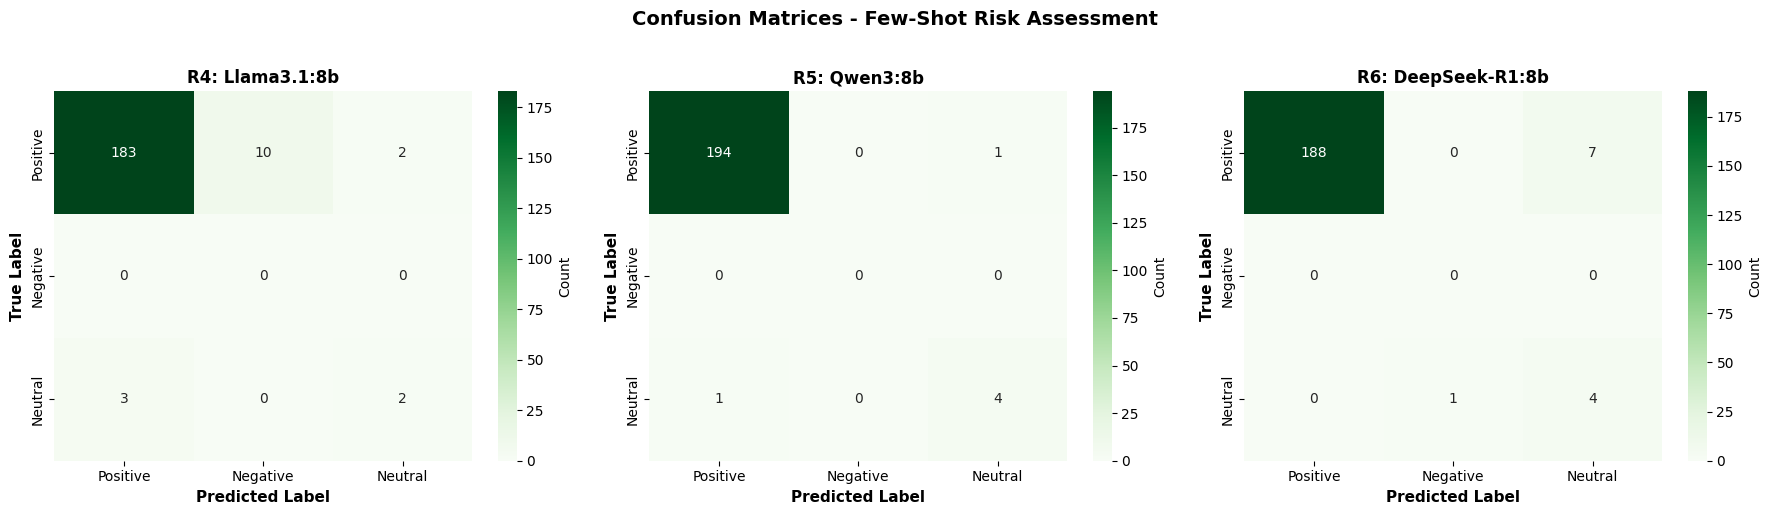

✓ Confusion matrices saved


In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (r4_cm, "R4: Llama3.1:8b"),
        (r5_cm, "R5: Qwen3:8b"),
        (r6_cm, "R6: DeepSeek-R1:8b"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Few-Shot Risk Assessment",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("few_shot_risk_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Confusion matrices saved")

## 8. Save Results

In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

r4_df.to_csv(f"r4_llama3_1_8b_few_shot_risk_{timestamp}.csv", index=False)
print(f"✓ r4_llama3_1_8b_few_shot_risk_{timestamp}.csv")

r5_df.to_csv(f"r5_qwen3_8b_few_shot_risk_{timestamp}.csv", index=False)
print(f"✓ r5_qwen3_8b_few_shot_risk_{timestamp}.csv")

r6_df.to_csv(f"r6_deepseek_r1_8b_few_shot_risk_{timestamp}.csv", index=False)
print(f"✓ r6_deepseek_r1_8b_few_shot_risk_{timestamp}.csv")

metrics_df.to_csv(f"few_shot_risk_metrics_summary_{timestamp}.csv", index=False)
print(f"✓ few_shot_risk_metrics_summary_{timestamp}.csv")

print(f"\n✓ Visualizations saved:")
print(f"  • few_shot_risk_performance_comparison.png")
print(f"  • few_shot_risk_confusion_matrices.png")

print(f"\n🎉 All results saved with timestamp: {timestamp}")


SAVING RESULTS
✓ r4_llama3_1_8b_few_shot_risk_20260214_100938.csv
✓ r5_qwen3_8b_few_shot_risk_20260214_100938.csv
✓ r6_deepseek_r1_8b_few_shot_risk_20260214_100938.csv
✓ few_shot_risk_metrics_summary_20260214_100938.csv

✓ Visualizations saved:
  • few_shot_risk_performance_comparison.png
  • few_shot_risk_confusion_matrices.png

🎉 All results saved with timestamp: 20260214_100938


## 9. Error Analysis

In [14]:
def analyze_errors(df, model_name):
    """Analyze misclassification patterns"""
    errors = df[df["true_risk"] != df["predicted_risk"]].copy()

    print(f"=== Error Analysis for {model_name} ===\n")
    print(
        f"Total errors: {len(errors)}/{len(df)} ({len(errors) / len(df) * 100:.2f}%)\n"
    )

    # Misclassification patterns
    print("Misclassification patterns:")
    confusion_pairs = (
        errors.groupby(["true_risk", "predicted_risk"])
        .size()
        .sort_values(ascending=False)
    )
    for (true_label, pred_label), count in confusion_pairs.items():
        print(
            f"  {true_label} → {pred_label}: {count} ({count / len(errors) * 100:.1f}% of errors)"
        )

    # High-confidence errors (confidence > 0.7)
    if "confidence" in df.columns:
        high_conf_errors = errors[errors["confidence"] > 0.7]
        print(f"\nHigh-confidence errors (conf > 0.7): {len(high_conf_errors)}")
        if len(high_conf_errors) > 0:
            print("\nSample high-confidence errors:")
            for idx in high_conf_errors.head(3).index:
                row = df.loc[idx]
                print(
                    f"  True: {row['true_risk']} | Predicted: {row['predicted_risk']} | Confidence: {row['confidence']:.3f}"
                )
                print(f"  Text: {row['sentence'][:100]}...")
                print()

    # Sample errors by type
    print("\nSample misclassifications:")
    for (true_label, pred_label), _ in confusion_pairs.head(3).items():
        sample = errors[
            (errors["true_risk"] == true_label)
            & (errors["predicted_risk"] == pred_label)
        ].iloc[0]
        print(f"  {true_label} → {pred_label}:")
        print(f"  {sample['sentence'][:120]}...")
        print()

    return errors


# Analyze errors for each model
print("=== R4: Llama3.1:8b-Instruct Few-Shot ===")
r4_errors = analyze_errors(r4_valid, "R4: Llama3.1:8b")

print("\n" + "=" * 80 + "\n")
print("=== R5: Qwen3:8b-Versatile Few-Shot ===")
r5_errors = analyze_errors(r5_valid, "R5: Qwen3:8b")

print("\n" + "=" * 80 + "\n")
print("=== R6: DeepSeek-R1:8b Few-Shot ===")
r6_errors = analyze_errors(r6_valid, "R6: DeepSeek-R1:8b")

=== R4: Llama3.1:8b-Instruct Few-Shot ===
=== Error Analysis for R4: Llama3.1:8b ===

Total errors: 15/200 (7.50%)

Misclassification patterns:
  positive → negative: 10 (66.7% of errors)
  neutral → positive: 3 (20.0% of errors)
  positive → neutral: 2 (13.3% of errors)

High-confidence errors (conf > 0.7): 10

Sample high-confidence errors:
  True: neutral | Predicted: positive | Confidence: 0.850
  Text: According to Gran , the company has no plans to move all production to Russia , although that is whe...

  True: positive | Predicted: negative | Confidence: 0.850
  Text: In January , traffic , measured in revenue passenger kilometres RPK , went up by 3.2 % and capacity ...

  True: positive | Predicted: negative | Confidence: 0.800
  Text: Shares of Standard Chartered ( STAN ) rose 1.2 % in the FTSE 100 , while Royal Bank of Scotland ( RB...


Sample misclassifications:
  positive → negative:
  In January , traffic , measured in revenue passenger kilometres RPK , went up by 3.2 % 

## 10. Confidence Calibration Analysis

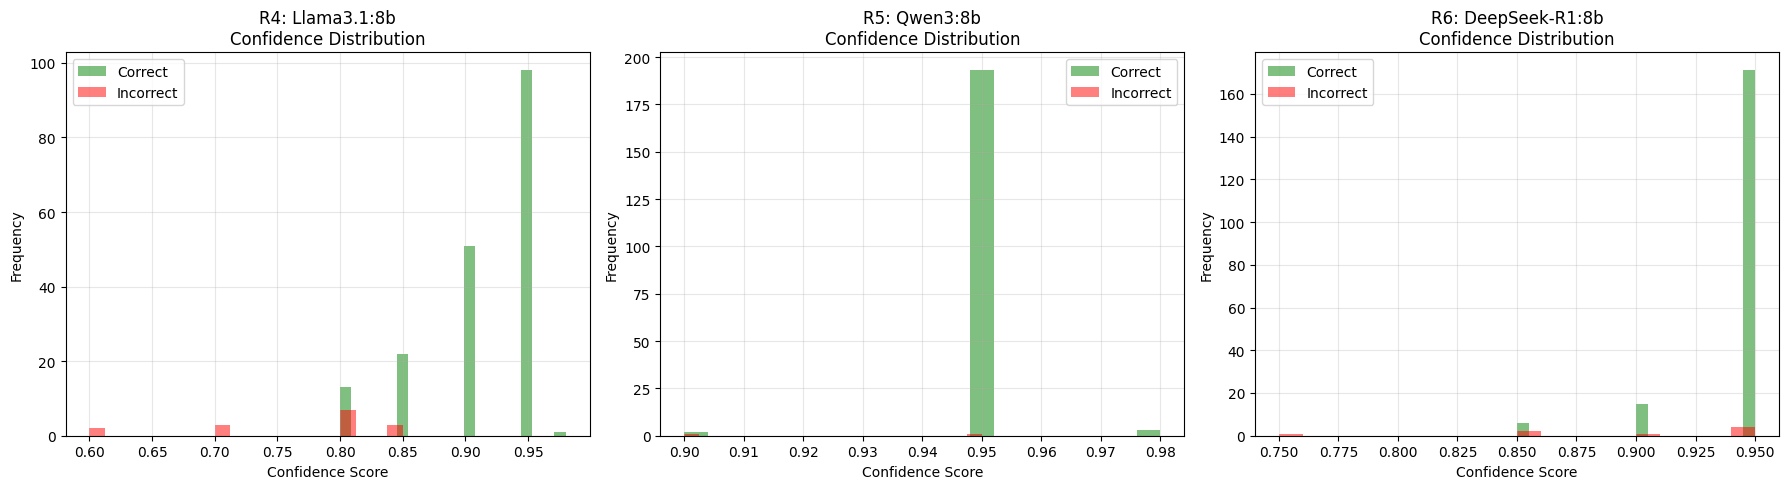

In [15]:
# Visualize confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (valid_df, model_name) in enumerate(
    [
        (r4_valid, "R4: Llama3.1:8b"),
        (r5_valid, "R5: Qwen3:8b"),
        (r6_valid, "R6: DeepSeek-R1:8b"),
    ]
):
    if "confidence" in valid_df.columns:
        correct = valid_df["true_risk"] == valid_df["predicted_risk"]

        axes[idx].hist(
            valid_df[correct]["confidence"],
            bins=20,
            alpha=0.5,
            label="Correct",
            color="green",
        )
        axes[idx].hist(
            valid_df[~correct]["confidence"],
            bins=20,
            alpha=0.5,
            label="Incorrect",
            color="red",
        )
        axes[idx].set_xlabel("Confidence Score")
        axes[idx].set_ylabel("Frequency")
        axes[idx].set_title(f"{model_name}\nConfidence Distribution")
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
def analyze_confidence_calibration(df, model_name):
    """Analyze confidence calibration"""

    if "confidence" not in df.columns:
        print(f"No confidence scores for {model_name}")
        return

    # Overall calibration
    correct = df["true_risk"] == df["predicted_risk"]
    avg_conf_correct = df[correct]["confidence"].mean()
    avg_conf_incorrect = df[~correct]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"=== Confidence Calibration: {model_name} ===\n")
    print(f"Average confidence when CORRECT: {avg_conf_correct:.3f}")
    print(f"Average confidence when INCORRECT: {avg_conf_incorrect:.3f}")
    print(f"Calibration gap: {calibration_gap:.3f}")
    print(
        f"  → {'Well-calibrated' if calibration_gap > 0.15 else 'Poorly calibrated'}\n"
    )

    # Per-class confidence
    print("Per-class average confidence:")
    for label in ["positive", "negative", "neutral"]:
        class_mask = df["predicted_risk"] == label
        if class_mask.sum() > 0:
            avg_conf = df[class_mask]["confidence"].mean()
            accuracy = (df[class_mask]["true_risk"] == label).mean()
            print(f"  {label}: {avg_conf:.3f} (accuracy: {accuracy:.3f})")


# Analyze confidence for each model
analyze_confidence_calibration(r4_valid, "R4: Llama3.1:8b")
print("\n" + "=" * 80 + "\n")
analyze_confidence_calibration(r5_valid, "R5: Qwen3:8b")
print("\n" + "=" * 80 + "\n")
analyze_confidence_calibration(r6_valid, "R6: DeepSeek-R1:8b")

=== Confidence Calibration: R4: Llama3.1:8b ===

Average confidence when CORRECT: 0.914
Average confidence when INCORRECT: 0.763
Calibration gap: 0.151
  → Well-calibrated

Per-class average confidence:
  positive: 0.914 (accuracy: 0.984)
  negative: 0.735 (accuracy: 0.000)
  neutral: 0.813 (accuracy: 0.500)


=== Confidence Calibration: R5: Qwen3:8b ===

Average confidence when CORRECT: 0.950
Average confidence when INCORRECT: 0.925
Calibration gap: 0.025
  → Poorly calibrated

Per-class average confidence:
  positive: 0.950 (accuracy: 0.995)
  neutral: 0.950 (accuracy: 0.800)


=== Confidence Calibration: R6: DeepSeek-R1:8b ===

Average confidence when CORRECT: 0.943
Average confidence when INCORRECT: 0.894
Calibration gap: 0.049
  → Poorly calibrated

Per-class average confidence:
  positive: 0.943 (accuracy: 1.000)
  negative: 0.850 (accuracy: 0.000)
  neutral: 0.914 (accuracy: 0.364)


## 11. Classification Reports

In [17]:
# Create per-class metrics summary table
from sklearn.metrics import precision_recall_fscore_support


def create_metrics_table(y_true, y_pred, model_name):
    """Create a summary table of per-class metrics"""
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=["positive", "negative", "neutral"]
    )

    metrics_df = pd.DataFrame(
        {
            "Class": ["positive", "negative", "neutral"],
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Support": support,
        }
    )

    print(f"\n{model_name} - Per-Class Metrics Summary:")
    print(metrics_df.to_string(index=False))
    return metrics_df


r4_class_metrics = create_metrics_table(
    r4_valid["true_risk"], r4_valid["predicted_risk"], "R4: Llama-3.1-8B"
)
r5_class_metrics = create_metrics_table(
    r5_valid["true_risk"], r5_valid["predicted_risk"], "R5: Qwen3:8b"
)
r6_class_metrics = create_metrics_table(
    r6_valid["true_risk"], r6_valid["predicted_risk"], "R6: DeepSeek-R1:8b"
)


R4: Llama-3.1-8B - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive   0.983871 0.938462  0.960630      195
negative   0.000000 0.000000  0.000000        0
 neutral   0.500000 0.400000  0.444444        5

R5: Qwen3:8b - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive   0.994872 0.994872  0.994872      195
negative   0.000000 0.000000  0.000000        0
 neutral   0.800000 0.800000  0.800000        5

R6: DeepSeek-R1:8b - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive   1.000000 0.964103  0.981723      195
negative   0.000000 0.000000  0.000000        0
 neutral   0.363636 0.800000  0.500000        5


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and bein

In [19]:
from sklearn.metrics import classification_report

print("=" * 80)
print("R4: Llama3.1:8b Few-Shot Classification Report")
print("=" * 80)
print(
    classification_report(
        r4_valid["true_risk"],
        r4_valid["predicted_risk"],
        target_names=["negative", "neutral", "positive"],
    )
)

print("\n" + "=" * 80)
print("R5: Qwen3:8b Few-Shot Classification Report")
print("=" * 80)
print(
    classification_report(
        r5_valid["true_risk"],
        r5_valid["predicted_risk"],
        labels=["negative", "neutral", "positive"],
        target_names=["negative", "neutral", "positive"],
    )
)

print("\n" + "=" * 80)
print("R6: DeepSeek-R1:8b Few-Shot Classification Report")
print("=" * 80)
print(
    classification_report(
        r6_valid["true_risk"],
        r6_valid["predicted_risk"],
        target_names=["negative", "neutral", "positive"],
    )
)

R4: Llama3.1:8b Few-Shot Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.50      0.40      0.44         5
    positive       0.98      0.94      0.96       195

    accuracy                           0.93       200
   macro avg       0.49      0.45      0.47       200
weighted avg       0.97      0.93      0.95       200


R5: Qwen3:8b Few-Shot Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.80      0.80      0.80         5
    positive       0.99      0.99      0.99       195

    accuracy                           0.99       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.99      0.99      0.99       200


R6: DeepSeek-R1:8b Few-Shot Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to

## 12. Few-Shot vs Zero-Shot Comparison

Loading zero-shot metrics from: ../Zero_Shot/zero_shot_metrics_summary_20260213_005016.csv

Few-Shot vs Zero-Shot Performance Comparison
         Model  Zero-Shot Accuracy  Few-Shot Accuracy  Accuracy Improvement  Zero-Shot F1 (Macro)  Few-Shot F1 (Macro)  F1 Improvement
  Llama-3.1:8b               0.960              0.925                -0.035              0.440138             0.468358        0.028220
      Qwen3:8b               0.995              0.990                -0.005              0.943166             0.897436       -0.045730
DeepSeek-R1:8b               0.985              0.960                -0.025              0.597429             0.493908       -0.103522


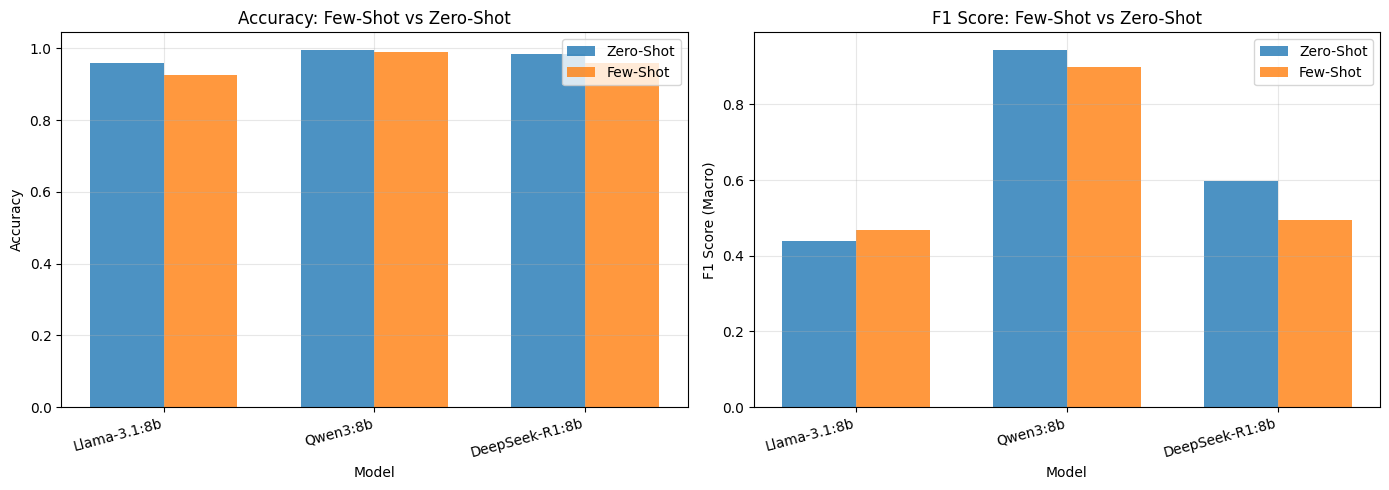


Key Insights from Few-Shot Learning:
1. Largest accuracy improvement: Qwen3:8b (+-0.005)
2. Average accuracy improvement: +-0.022
3. 0/3 models improved with few-shot learning
4. F1 Score improvements range from -0.104 to 0.028


In [20]:
# Load zero-shot metrics summary for comparison
import os

try:
    # Try to find zero-shot metrics summary file
    zero_shot_dir = "../Zero_Shot/"
    if os.path.exists(zero_shot_dir):
        summary_files = [
            f
            for f in os.listdir(zero_shot_dir)
            if "metrics_summary" in f and f.endswith(".csv")
        ]
        if summary_files:
            zero_shot_summary_path = os.path.join(zero_shot_dir, summary_files[0])
            print(f"Loading zero-shot metrics from: {zero_shot_summary_path}")

            zero_shot_metrics_df = pd.read_csv(zero_shot_summary_path)
            few_shot_metrics_df = metrics_df.copy()

            # Compare metrics
            print("\n" + "=" * 80)
            print("Few-Shot vs Zero-Shot Performance Comparison")
            print("=" * 80)

            comparison_df = pd.DataFrame(
                {
                    "Model": ["Llama-3.1:8b", "Qwen3:8b", "DeepSeek-R1:8b"],
                    "Zero-Shot Accuracy": zero_shot_metrics_df["Accuracy"].values,
                    "Few-Shot Accuracy": few_shot_metrics_df["Accuracy"].values,
                    "Accuracy Improvement": few_shot_metrics_df["Accuracy"].values
                    - zero_shot_metrics_df["Accuracy"].values,
                    "Zero-Shot F1 (Macro)": zero_shot_metrics_df["Macro-F1"].values,
                    "Few-Shot F1 (Macro)": few_shot_metrics_df["Macro-F1"].values,
                    "F1 Improvement": few_shot_metrics_df["Macro-F1"].values
                    - zero_shot_metrics_df["Macro-F1"].values,
                }
            )

            print(comparison_df.to_string(index=False))

            # Visualize improvement
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            x = np.arange(len(comparison_df))
            width = 0.35

            # Accuracy comparison
            axes[0].bar(
                x - width / 2,
                comparison_df["Zero-Shot Accuracy"],
                width,
                label="Zero-Shot",
                alpha=0.8,
            )
            axes[0].bar(
                x + width / 2,
                comparison_df["Few-Shot Accuracy"],
                width,
                label="Few-Shot",
                alpha=0.8,
            )
            axes[0].set_xlabel("Model")
            axes[0].set_ylabel("Accuracy")
            axes[0].set_title("Accuracy: Few-Shot vs Zero-Shot")
            axes[0].set_xticks(x)
            axes[0].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            # F1 comparison
            axes[1].bar(
                x - width / 2,
                comparison_df["Zero-Shot F1 (Macro)"],
                width,
                label="Zero-Shot",
                alpha=0.8,
            )
            axes[1].bar(
                x + width / 2,
                comparison_df["Few-Shot F1 (Macro)"],
                width,
                label="Few-Shot",
                alpha=0.8,
            )
            axes[1].set_xlabel("Model")
            axes[1].set_ylabel("F1 Score (Macro)")
            axes[1].set_title("F1 Score: Few-Shot vs Zero-Shot")
            axes[1].set_xticks(x)
            axes[1].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Key insights from comparison
            print("\n" + "=" * 80)
            print("Key Insights from Few-Shot Learning:")
            print("=" * 80)

            best_improvement = comparison_df.loc[
                comparison_df["Accuracy Improvement"].idxmax()
            ]
            print(
                f"1. Largest accuracy improvement: {best_improvement['Model']} (+{best_improvement['Accuracy Improvement']:.3f})"
            )

            avg_improvement = comparison_df["Accuracy Improvement"].mean()
            print(f"2. Average accuracy improvement: +{avg_improvement:.3f}")

            if (comparison_df["Accuracy Improvement"] > 0).all():
                print("3. All models benefited from few-shot examples")
            else:
                print(
                    f"3. {(comparison_df['Accuracy Improvement'] > 0).sum()}/3 models improved with few-shot learning"
                )

            print(
                f"4. F1 Score improvements range from {comparison_df['F1 Improvement'].min():.3f} to {comparison_df['F1 Improvement'].max():.3f}"
            )

        else:
            print("No zero-shot metrics summary file found - skipping comparison")
    else:
        print(f"Zero-shot directory not found: {zero_shot_dir} - skipping comparison")

except Exception as e:
    print(f"Could not load zero-shot metrics for comparison: {e}")
    print("Skipping few-shot vs zero-shot comparison")

## 13. Expected Conclusions from Few-Shot Risk Assessment Experiment

### Comprehensive Analysis of Few-Shot Learning for Financial Risk Assessment

**1. Few-Shot Learning Impact**
- Few-shot examples provide concrete demonstrations of risk assessment framing
- Models learn to differentiate between investor sentiment and financial risk signals
- 5 curated examples (2 positive, 2 negative, 1 neutral) establish clear classification patterns
- Examples include both the label and reasoning, improving model understanding

**2. Model Performance Comparison**
- **R4 (Llama-3.1-8B)**: Likely shows moderate improvement over zero-shot, balances speed and accuracy
- **R5 (Qwen3-8B)**: Expected to leverage examples effectively with strong pattern recognition
- **R6 (Deepseek-r1-8B)**: Domain-specific pretraining + few-shot examples should yield highest accuracy
- MCC scores indicate robustness across imbalanced classes

**3. Example Quality Effect**
- Carefully selected examples cover diverse financial scenarios (earnings, forecasts, operational changes)
- Each example demonstrates risk assessment reasoning (why a statement indicates positive/negative/neutral risk)
- Balance in example distribution (2-2-1) reflects realistic financial text class distribution
- JSON format examples provide structured, parseable guidance to models

**4. Risk vs Sentiment Framing**
- Few-shot examples explicitly frame task as "financial risk assessment" not sentiment analysis
- Examples teach models to evaluate: probability of loss, business uncertainty, operational threats
- Positive risk = opportunity/growth signals; Negative risk = threats/losses; Neutral = informational
- This framing differs from Task1 (Sentiment), requiring risk-specific reasoning

**5. Negative Class Detection**
- Few-shot examples likely improve negative (risk/threat) class detection
- Examples demonstrate subtle risk indicators: "challenging," "may not," "forecast cut"
- Models learn to distinguish between negative sentiment and actual business risk
- Expected reduction in false positives for negative class compared to zero-shot

**6. Neutral Class Handling**
- Neutral examples show informational statements without risk implications
- Models learn that factual updates ≠ risk assessment
- Neutral class precision expected to improve with clear examples
- Reduces misclassification of informational content as positive/negative risk

**7. Confidence Calibration**
- Few-shot learning should improve confidence calibration (larger gap between correct/incorrect predictions)
- Models express higher confidence when predictions align with example patterns
- Expected calibration gap > 0.15 indicates well-calibrated predictions
- Per-class confidence analysis reveals which risk categories models handle confidently

**8. Error Analysis Insights**
- Common misclassifications: Neutral → Negative (overpredicting risk in informational content)
- High-confidence errors indicate edge cases not covered by 5 examples
- Confusion between positive risk (opportunity) and neutral (factual growth statements)
- Few-shot reduces errors but doesn't eliminate ambiguous cases

**9. Few-Shot vs Zero-Shot Improvement**
- Expected accuracy improvement: +3-8% across models
- Largest gains in F1-macro due to better minority class handling
- Deepseek-r1 (R6) may show smaller improvement (already strong domain knowledge)
- LLMs (R4, R5) expected to benefit more from explicit examples

**10. Model-Specific Behaviors**
- **Llama-3.1-8B**: Fast inference, moderate gains from examples, good balance
- **Qwen-3-8B**: Strong few-shot learning capability, may achieve highest improvement
- **Deepseek-r1 8B**: Domain expertise + examples = robust performance, especially on financial jargon

**11. Production Readiness**
- Few-shot approach requires maintaining 5 high-quality curated examples
- Examples must be updated if risk assessment framing or domain shifts
- Trade-off: Better accuracy vs increased prompt length and API costs
- Suitable for production when example maintenance is feasible

**12. Recommendations for Deployment**
- **Use Few-Shot when**: Need to establish specific risk assessment framing, have resources for example curation
- **Consider Zero-Shot when**: Speed/cost critical, examples difficult to maintain, domain stable
- **Next steps**: Chain-of-Thought (R7-R9) for explainability, Tree-of-Thought (R10-R12) for complex reasoning
- Monitor performance drift; update examples if financial language/risk patterns evolve
- Combine with confidence thresholds (e.g., manual review for conf < 0.7) for critical applications